In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# For inline display of images in Jupyter Notebook
%matplotlib inline

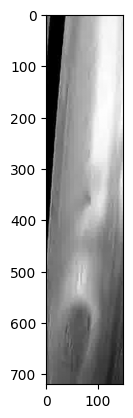

In [192]:
image_path = "/Users/krishnaiyer/structure-health-monitoring-railway/dataset/raw/Squats/7.MOV_20201228114152_8192.JPEG"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Crop image
half_width = 200
h, w = image.shape[:2]
center_x = w // 2
left = max(center_x - int(0.15*half_width), 0)
right = min(center_x + int(0.6*half_width), w)
cropped_image = image[:, left:right]


#display
plt.imshow(cropped_image, cmap='gray')

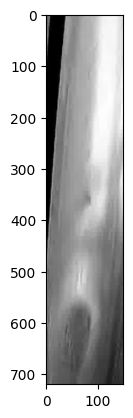

In [193]:
#step 2a : bilateral filtering
filtered = cropped_image.copy()
bilateral_filtered = cv2.bilateralFilter(filtered, d=3, sigmaColor=75, sigmaSpace=75)
plt.imshow(bilateral_filtered, cmap='gray')

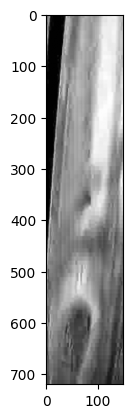

In [194]:
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
contrastive_image = clahe.apply(bilateral_filtered)
plt.imshow(contrastive_image, cmap='gray')

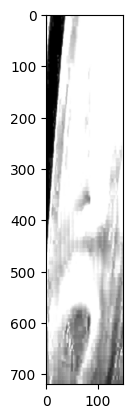

In [211]:
# Compute the Laplacian (edge map) of the image
laplacian = cv2.Laplacian(contrastive_image, cv2.CV_64F)
# Convert the edge map to an 8-bit unsigned type
laplacian = cv2.convertScaleAbs(laplacian)
# Blend the original image with the Laplacian image
sharpened = cv2.addWeighted(contrastive_image, 1.75, laplacian, 1, 0)
plt.imshow(sharpened, cmap='gray')

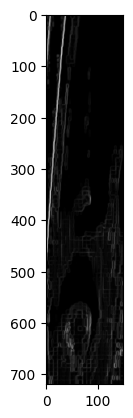

In [212]:
# step 3 : Apply Sobel edge detection
# Initialize an array to hold the maximum gradient magnitude.
edge_map = np.zeros_like(sharpened, dtype=np.float32)
scales = [3]
for ksize in scales:
    # Compute gradients in x and y directions
    grad_x = cv2.Sobel(sharpened, cv2.CV_32F, 1, 0, ksize=ksize)
    grad_y = cv2.Sobel(sharpened, cv2.CV_32F, 0, 1, ksize=ksize)
    
    # Compute the gradient magnitude
    magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Update the edge map with the maximum magnitude at each pixel
    edge_map = np.maximum(edge_map, magnitude)

# Normalize the edge map to 0-255 and convert to uint8
edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX)
#_, edge_map = cv2.threshold(edge_map, 100, 255, cv2.THRESH_BINARY)  # Higher threshold
plt.imshow(edge_map, cmap='gray')

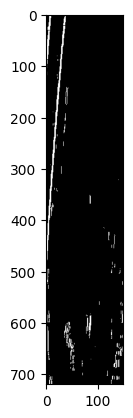

In [215]:
# Assuming 'edge_map' is your current thick edge image
def skeletonize(image):
    image = image.astype(np.uint8)
    # Ensure binary image
    _, binary = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Initialize skeleton
    skeleton = np.zeros(binary.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))

    while True:
        # Erosion and opening
        eroded = cv2.erode(binary, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(binary, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        binary = eroded.copy()

        if cv2.countNonZero(binary) == 0:
            break

    return skeleton
thinned_edges = skeletonize(edge_map)

plt.imshow(thinned_edges, cmap='gray')

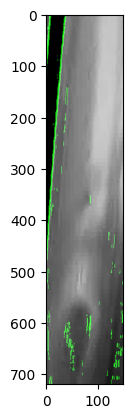

In [216]:
# Step 1: Convert original grayscale image to BGR
image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)

# Step 2: Create a green mask for the thinned edges
green_mask = np.zeros_like(image_bgr)
green_mask[thinned_edges == 255] = [0, 255, 0]  # Green in BGR

# Step 3: Overlay the green edges on the original image
# Blend with some transparency (alpha blending)
overlay = cv2.addWeighted(image_bgr, 0.8, green_mask, 0.8, 0)
plt.imshow(overlay)